In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!curl -L "https://app.roboflow.com/ds/T9nOGsPdnS?key=iNSAHdn1mM" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
%cd /content/
%mkdir images/
%mv train images/train
%mv valid images/valid

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   894  100   894    0     0   2561      0 --:--:-- --:--:-- --:--:--  2554
100 11.0M  100 11.0M    0     0  12.0M      0 --:--:-- --:--:-- --:--:-- 12.0M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: train/
   creating: train/imagery satellite with fire/
 extracting: train/imagery satellite with fire/100_jpg.rf.a3a550d42742b14118cea113c67246e6.jpg  
 extracting: train/imagery satellite with fire/100_jpg.rf.b7dd566e83a14cb44aa52373f939df07.jpg  
 extracting: train/imagery satellite with fire/100_jpg.rf.c8985e0ef36a8a9424d0742e4f1a881a.jpg  
 extracting: train/imagery satellite with fire/102_jpg.rf.ace98147e50af85161c77067640da6b8.jpg  
 extracting: train/imagery satellite with fire/102_jpg.rf.b75a591284bcc68fb1ed58c3dbbd59b6.jpg  
 extracting: train/imagery satellite with fire/102_jpg.rf.c942aa11ff5f

In [3]:
import tensorflow_datasets as tfds
builder = tfds.folder_dataset.ImageFolder('images/')
print(builder.info)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
raw_valid = builder.as_dataset(split='valid', shuffle_files=True)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='images/',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=2250, num_shards=1>,
        'valid': <SplitInfo num_examples=200, num_shards=1>,
    },
    citation="""""",
)


In [4]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(pair):
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [5]:
train = raw_train.map(format_example)
validation = raw_valid.map(format_example)


In [6]:
BATCH_SIZE = 14
SHUFFLE_BUFFER_SIZE = 500

In [7]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)


In [8]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([14, 160, 160, 3])

In [9]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [10]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(14, 5, 5, 1280)


In [11]:
base_model.trainable = False

In [12]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(14, 1280)


In [14]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(14, 1)


In [15]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
len(model.trainable_variables)

2

In [20]:
initial_epochs = 20
validation_steps=14

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

14/14 [==============================] - 0s 18ms/step - loss: 0.7547 - accuracy: 0.5051


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.75
initial accuracy: 0.51


In [22]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/20
161/161 [==============================] - 8s 27ms/step - loss: 0.5086 - accuracy: 0.7111 - val_loss: 0.3679 - val_accuracy: 0.8750
Epoch 2/20
161/161 [==============================] - 4s 24ms/step - loss: 0.3043 - accuracy: 0.8933 - val_loss: 0.2473 - val_accuracy: 0.9150
Epoch 3/20
161/161 [==============================] - 4s 23ms/step - loss: 0.2162 - accuracy: 0.9324 - val_loss: 0.1811 - val_accuracy: 0.9450
Epoch 4/20
161/161 [==============================] - 4s 23ms/step - loss: 0.1731 - accuracy: 0.9462 - val_loss: 0.1498 - val_accuracy: 0.9550
Epoch 5/20
161/161 [==============================] - 4s 24ms/step - loss: 0.1468 - accuracy: 0.9538 - val_loss: 0.1338 - val_accuracy: 0.9500
Epoch 6/20
161/161 [==============================] - 4s 23ms/step - loss: 0.1287 - accuracy: 0.9582 - val_loss: 0.1132 - val_accuracy: 0.9750
Epoch 7/20
161/161 [==============================] - 4s 24ms/step - loss: 0.1157 - accuracy: 0.9631 - val_loss: 0.1038 - val_accuracy: 0.9750

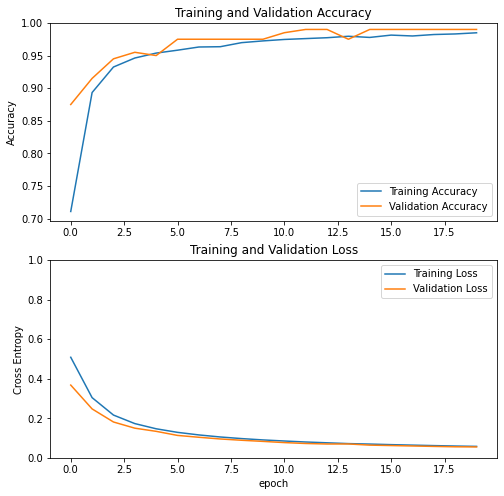

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [30]:
len(model.trainable_variables)

56

In [31]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 20/40
161/161 [==============================] - 12s 36ms/step - loss: 0.2294 - accuracy: 0.8747 - val_loss: 0.1052 - val_accuracy: 0.9600
Epoch 21/40
161/161 [==============================] - 5s 30ms/step - loss: 0.1020 - accuracy: 0.9627 - val_loss: 0.1347 - val_accuracy: 0.9550
Epoch 22/40
161/161 [==============================] - 5s 30ms/step - loss: 0.0756 - accuracy: 0.9720 - val_loss: 0.1636 - val_accuracy: 0.9500
Epoch 23/40
161/161 [==============================] - 5s 31ms/step - loss: 0.0688 - accuracy: 0.9796 - val_loss: 0.1406 - val_accuracy: 0.9550
Epoch 24/40
161/161 [==============================] - 5s 31ms/step - loss: 0.0418 - accuracy: 0.9849 - val_loss: 0.1610 - val_accuracy: 0.9550
Epoch 25/40
161/161 [==============================] - 6s 38ms/step - loss: 0.0279 - accuracy: 0.9920 - val_loss: 0.1593 - val_accuracy: 0.9550
Epoch 26/40
161/161 [==============================] - 6s 35ms/step - loss: 0.0190 - accuracy: 0.9960 - val_loss: 0.1275 - val_accuracy

In [32]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

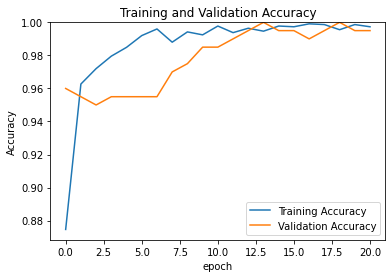

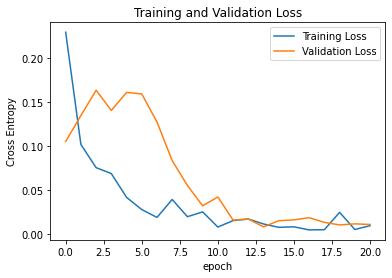

In [42]:
plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


plt.figure()
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save("/content/mobilenet.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
